In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import random

In [2]:
def f(x):
    return 3*x**2 + 4*x +2

In [3]:
xs = np.arange(-5,12,0.1)

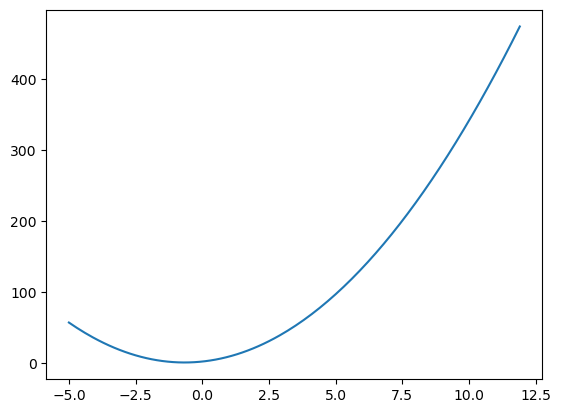

In [4]:
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.001
x = -2/3
(f(x+h)-f(x))/h

0.0029999999997532

In [6]:
a = 5.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b + c
print(d1)
print(d2)
print((d2-d1)/h)

-5.0
-4.9990000000000006
0.9999999999994458


In [7]:
class Value:
    def __init__(self,data, _children = (), _op = '',label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        return f'Value: {self.data}'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self,other):
        return self*other
    
        
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        #other = other if isinstance(other,Value) else Value(other)
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/ (math.exp(2*n)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self,other):
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self): # -self
        return self * -1

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [8]:
a = Value(2.0)
a**2

Value: 4.0

In [9]:
a = Value(2.0,label = 'a')
b = Value(-6.0,label = 'b')
c = Value(-0.5, label = 'c')
e = a+b
e.label = 'e'
d = e*c
d.label = 'd'
f = Value(2.0)
L = d*f
#L.data += 50
L.tanh()
M = L **3
#L.grad = 1.0
#print(d.grad)
#print(L._backward())
#print(d.grad)
L.backward()

In [10]:
print(e.grad)

-1.0


In [11]:
for l in L._prev:
    print(l._prev)
#d._op

{Value: -0.5, Value: -4.0}
set()


In [12]:
L._prev

{Value: 2.0, Value: 2.0}

In [13]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum(wi*xi for wi,xi in zip(self.w,x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,nin,nout):
        self.Neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.Neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.Neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
          x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
            

In [14]:
x = [2.0,3.0]
n = Layer(2,3)
n(x)

[Value: 0.9997014358212191,
 Value: -0.9987604611257143,
 Value: 0.08062370534217955]

In [15]:
n = MLP(3,[4,4,1])

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [16]:
ypred = [n(x) for x in xs]
ypred

[Value: -0.0689796194251931,
 Value: 0.11039509103858954,
 Value: -0.1972949977306704,
 Value: -0.2362480768312413]

In [17]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [18]:
loss

Value: 4.548339313086176

In [19]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 4.548339313086176
1 2.8663029910650155
2 3.1614171192208698
3 3.0861692683678568
4 1.040224788311145
5 0.3188138158140119
6 0.05061364547249195
7 0.04295484856172181
8 0.03761410598386887
9 0.033583132266706596
10 0.03038896118415685
11 0.02777467776152539
12 0.025585273012244406
13 0.02371976448580608
14 0.02210852064244136
15 0.02070142858327375
16 0.01946121475751947
17 0.018359425458183986
18 0.01737387872003195
19 0.016486978925975972
